In [1]:
from lib.puzzles_generator_MET import prepare_data_p, prepare_data_v, prepare_fragments
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [2]:
frg = 48
sp = 8
nb = 3

In [3]:
data_p = prepare_data_p('/home/david/Bases/met/', fragment_per_side=nb, fragment_size=frg, space=sp, batch_size=1, data_aug=False, phase='val')

puzzle size 224


8


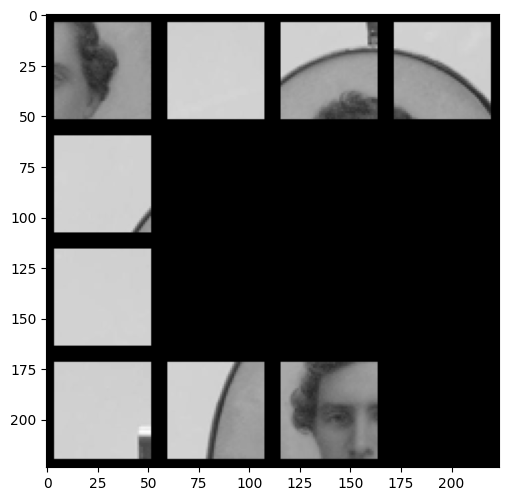

In [4]:
img, label, mask = data_p[0]
img = img.transpose(1,2,0).squeeze()
img = (img - np.min(img))/np.ptp(img)
print(label)
plt.imshow(img)

In [5]:
mask

array([[[1., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 1., 0.]]])

In [6]:
data_v = prepare_data_v('/home/david/Bases/met/', fragment_per_side=nb, fragment_size=frg, space=sp, batch_size=1, phase='val', nb_helpers=1, data_aug=False)

[0.]


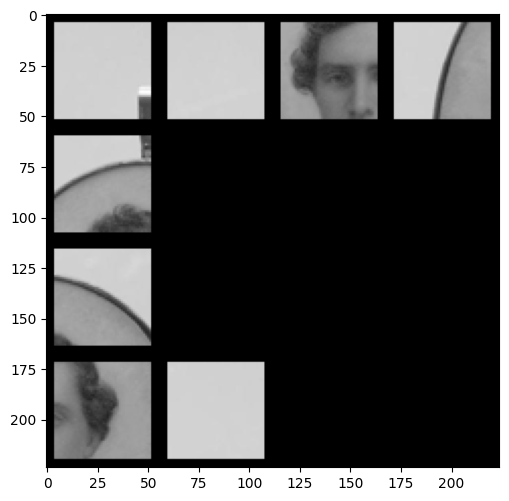

In [7]:
x, label, mask = data_v[0]
img = x.transpose(1,2,0).squeeze()
img = (img - np.min(img))/np.ptp(img)
print(label)
plt.imshow(img)

In [8]:
mask

array([[[1., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 0., 0.]]])

In [9]:
import observable_state, reassembly, game

In [10]:
args = {
    'dir_global': '/home/david/Bases/met/', 
    'puzzle_size': (frg+sp)*nb, 
    'fragment_per_side': nb, 
    'fragment_size': frg, 
    'space_size': sp,
    'fragments_nb': nb*nb
}
g = game.Game(args['puzzle_size'], args['fragment_size'], args['fragments_nb'], space=args['space_size'])
fragments_loader = prepare_fragments(path=args['dir_global'], phase='val',
                                  puzzle_size=args['puzzle_size'], fragment_per_side=args['fragment_per_side'],
                                  fragment_size=args['fragment_size'], space=args['space_size'])

In [11]:
g = game.Game(args['puzzle_size'], args['fragment_size'], args['fragments_nb'], space=args['space_size'])
fragments, solution_dicts = fragments_loader.prepare_problem(0)
print(solution_dicts)
for i in range(0, args['fragments_nb']):
    solution_dicts[i]['position'] = -1

[{'idx': 0, 'position': 3}, {'idx': 1, 'position': 7}, {'idx': 2, 'position': 1}, {'idx': 3, 'position': 5}, {'idx': 4, 'position': 4}, {'idx': 5, 'position': 0}, {'idx': 6, 'position': 6}, {'idx': 7, 'position': 2}, {'idx': 8, 'position': 8}]


In [12]:
nn_puzzle = g.pnet_input(solution_dicts, fragments, verbose=True)

[0, 1, 2, 3, 4, 5, 6, 7, 8] [{'idx': 0, 'position': -1}, {'idx': 1, 'position': -1}, {'idx': 2, 'position': -1}, {'idx': 3, 'position': -1}, {'idx': 4, 'position': -1}, {'idx': 5, 'position': -1}, {'idx': 6, 'position': -1}, {'idx': 7, 'position': -1}, {'idx': 8, 'position': -1}]


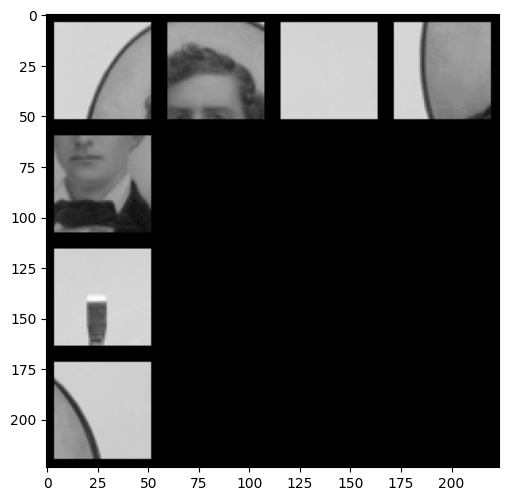

In [13]:
puz = nn_puzzle.squeeze().cpu().numpy().transpose(1,2,0)
puz = (puz - np.min(puz))/np.ptp(puz)
plt.imshow(puz)

In [14]:
args['conv_head'] = True
global VERBOSE
VERBOSE = False
args['p_weight_path']= 'tb_logs/model_p_48-8-48-8-48_h2/version_2/checkpoints/model_p-epoch=278-val_loss=1.097.ckpt'
#args['v_weight_path']='tb_logs/model_v_64-8-64-8-64_h8/version_0/checkpoints/model_v-epoch=030-val_loss=0.026.ckpt'
args['v_weight_path']= 'tb_logs/model_v_48-8-48-8-48_h0/version_1/checkpoints/model_v-epoch=063-val_loss=0.180.ckpt'
p_net, v_net = reassembly.prepare_nnets(args)


224 56 8
rdim: 512
p weights loaded from tb_logs/model_p_48-8-48-8-48_h2/version_2/checkpoints/model_p-epoch=278-val_loss=1.097.ckpt
rdim: 512
v weights loaded from tb_logs/model_v_48-8-48-8-48_h0/version_1/checkpoints/model_v-epoch=063-val_loss=0.180.ckpt


In [15]:
import torch
from lib.utils import sigmoid

In [16]:
g = game.Game(args['puzzle_size'], args['fragment_size'], args['fragments_nb'], space=args['space_size'])
fragments, solution_dicts = fragments_loader.prepare_problem(1)
print(solution_dicts)
for i in range(0, args['fragments_nb']):
    solution_dicts[i]['position'] = -1

[{'idx': 0, 'position': 7}, {'idx': 1, 'position': 1}, {'idx': 2, 'position': 5}, {'idx': 3, 'position': 0}, {'idx': 4, 'position': 6}, {'idx': 5, 'position': 8}, {'idx': 6, 'position': 4}, {'idx': 7, 'position': 2}, {'idx': 8, 'position': 3}]


In [17]:
tr = []
for i in range(nb**2):
    solution_dicts[0]['position'] = i
    tr.append(g.pnet_input(solution_dicts, fragments, verbose=False))

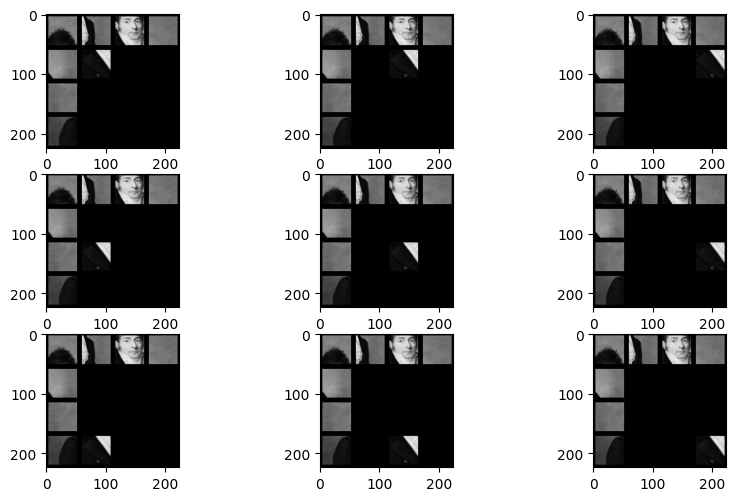

In [18]:
for i in range(nb**2):
    plt.subplot(nb, nb, 1+i)
    im = tr[i].squeeze().detach().cpu().numpy()
    plt.imshow(im.transpose(1,2,0))

In [19]:
v_net(torch.cat(tr).cuda()).detach().cpu().numpy()

array([[3.01e-05],
       [3.26e-05],
       [4.49e-05],
       [6.34e-05],
       [6.46e-04],
       [3.49e-04],
       [4.85e-04],
       [1.56e-03],
       [9.95e-04]], dtype=float32)

In [20]:
v_net(nn_puzzle)[0].detach().cpu().numpy()

array([0.], dtype=float32)

In [21]:
bs = 16
x = []
y = []
m = []
for i in range(bs):
    u, v, w = data_v[i]
    x.append(u)
    y.append(v)
    m.append(w)
y = torch.tensor(np.array(y).squeeze()).cuda()

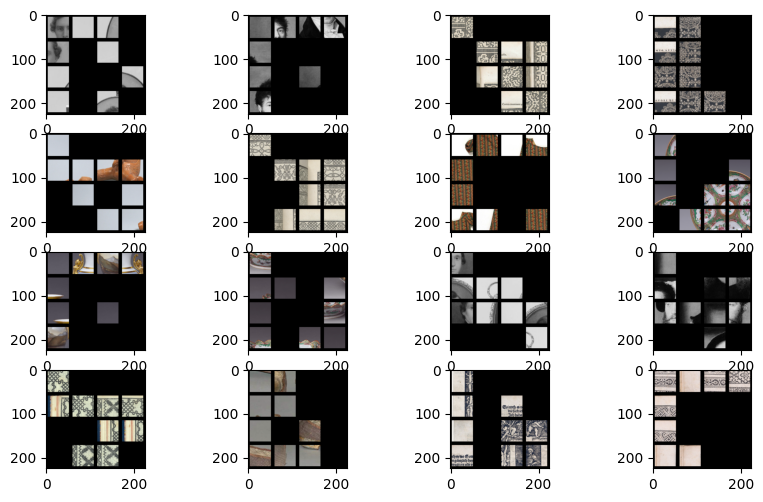

In [22]:
for i in range(min(bs, 16)):
    plt.subplot(4, 4, 1+i)
    plt.imshow(x[i].squeeze().transpose(1,2,0))

In [23]:
y

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6111, 0.8333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.7222, 0.7778, 0.0000],
       device='cuda:0', dtype=torch.float64)

In [24]:
y_ = v_net(torch.tensor(x).cuda(), torch.tensor(m).cuda()).squeeze()

In [25]:
y_

tensor([6.5304e-01, 1.4765e-05, 2.4206e-05, 3.0629e-05, 2.8920e-05, 2.1763e-05,
        3.2774e-01, 8.6826e-01, 2.4070e-05, 1.3704e-05, 8.0018e-05, 9.5080e-05,
        1.1549e-05, 6.6910e-01, 7.8927e-01, 2.6930e-01], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [26]:
(y_>0.5).int()

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0',
       dtype=torch.int32)

In [27]:
((y_>0.5).float() == y).sum()/bs

tensor(0.6875, device='cuda:0')

In [28]:
((y_>0.5).float() == y)

tensor([False,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True, False, False,  True], device='cuda:0')

In [29]:
def nb_puz(k, n):
    l = [i for i in range(n-k+1, n+1)]
    return np.prod(l)

In [30]:
nb_puz(2, 25)

600